<a href="https://colab.research.google.com/github/prikshit-2000/Tensorflow/blob/main/Saimese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from keras import backend as K
from PIL import Image,ImageDraw,ImageFont
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydot
from tensorflow.python.keras.utils.vis_utils import plot_model

In [2]:
def create_pairs(x,digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) -1
    for d in range(10):
        for i in range(n):
            z1,z2 = digit_indices[d][i],digit_indices[d][i+1]
            pairs +=[[x[z1],x[z2]]]
            inc = random.randrange(1,10)
            dn  = (d + inc)%10
            z1,z2 = digit_indices[d][i],digit_indices[dn][i+1]
            pairs +=[[x[z1],x[z2]]]
            labels +=[1,0]
    return np.array(pairs),np.array(labels)

def create_pairs_on_set(images , labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs , y = create_pairs(images , digit_indices)
    y = y.astype('float32')

    return pairs,y

def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [3]:
(train_images , train_labels) , (test_images , test_labels) = fashion_mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images =train_images / 255.0
test_images = test_images / 255.0
tr_pairs , tr_labels = create_pairs_on_set(train_images , train_labels)
ts_pairs , ts_labels = create_pairs_on_set(test_images , test_labels)

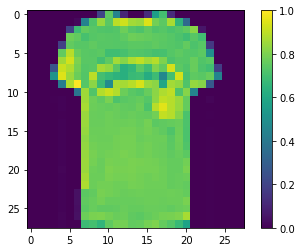

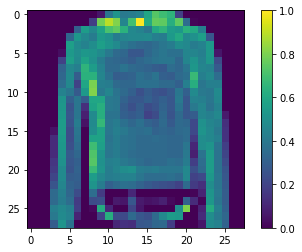

0.0


In [4]:
this_pair = 1
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])
print(ts_labels[this_pair])

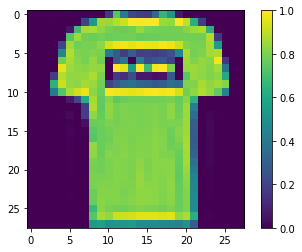

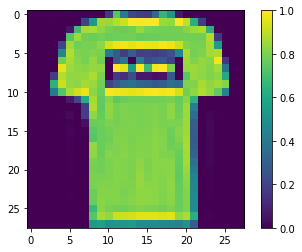

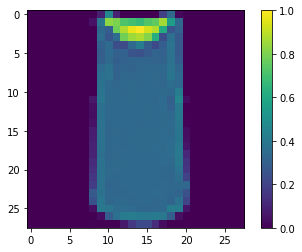

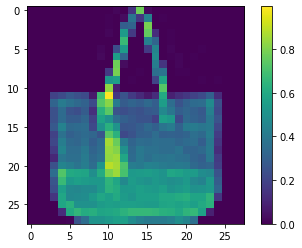

In [5]:
show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

In [6]:
def initialize_base_network():
    input = Input(shape = (28,28,))
    x = Flatten()(input)
    x = Dense(128,activation = 'relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128,activation = 'relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128,activation = 'relu')(x)
    
    model = Model(inputs = input , outputs = x)
    return model

def euclidean_distance(vects):
    x , y = vects
    sum_square = K.sum(K.square(x-y),axis = 1 , keepdims=True)
    return K.sqrt(K.maximum(sum_square , K.epsilon()))

def eucl_dist_shape(shapes):
    shape1 , shape2 = shapes
    return (shape1[0],1)


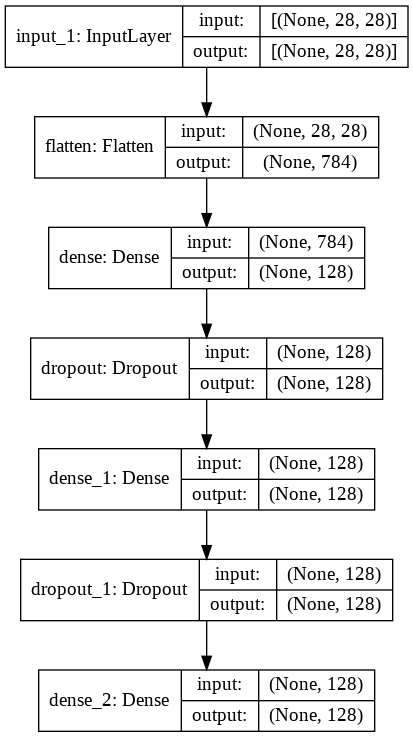

In [7]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')


In [8]:
input_a = Input(shape = (28,28,),name = 'left_input')
input_b = Input(shape = (28,28,) , name = 'left_output')
vector_a = base_network(input_a)
vector_b = base_network(input_b)

output = Lambda(euclidean_distance,name = 'output_layer',output_shape = eucl_dist_shape)([vector_a,vector_b])
model = Model(inputs = [input_a,input_b],outputs =output)

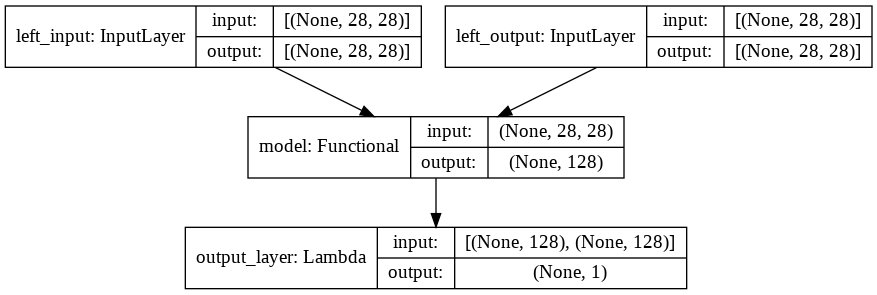

In [9]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [10]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true,y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred , 0 ))
        return (y_true * square_pred  + (1- y_true)*margin_square)
    return contrastive_loss

In [11]:
rms = RMSprop()
model.compile(optimizer=rms , loss = contrastive_loss_with_margin(margin = 1))
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_labels, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_labels))

Epoch 1/20
938/938 [==============================] - 11s 10ms/step - loss: 0.1107 - val_loss: 0.0867
Epoch 2/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0799 - val_loss: 0.0793
Epoch 3/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0717 - val_loss: 0.0700
Epoch 4/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0668 - val_loss: 0.0680
Epoch 5/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0634 - val_loss: 0.0685
Epoch 6/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0614 - val_loss: 0.0674
Epoch 7/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0592 - val_loss: 0.0666
Epoch 8/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0579 - val_loss: 0.0659
Epoch 9/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0569 - val_loss: 0.0639
Epoch 10/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0559 - val_loss: 0.0

In [12]:
def compute_accuracy(y_true,y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [13]:
loss = model.evaluate(x  =[ts_pairs[:,0],ts_pairs[:,1]] , y = ts_labels)

y_pred_train = model.predict(x = [tr_pairs[:,0],tr_pairs[:,1]] )
train_accuracy = compute_accuracy(tr_labels , y_pred_train)

y_pred_test = model.predict(x = [ts_pairs[:,0],ts_pairs[:,1]] )
test_accuracy = compute_accuracy(ts_labels , y_pred_test)

print(" Loss : {} , Train Accuracy : {} ,Test Accuracy : {}".format(loss,train_accuracy , test_accuracy))

625/625 [==============================] - 1s 2ms/step - loss: 0.0646


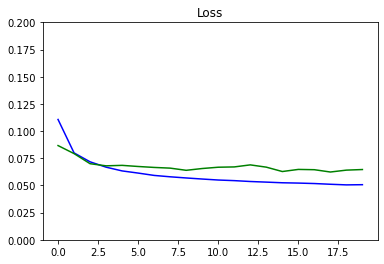

In [24]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [23]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)



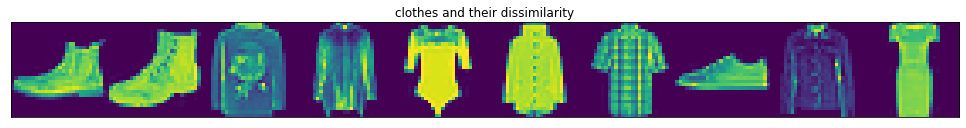

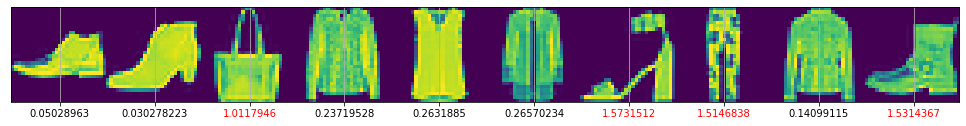

In [27]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_labels[indexes], "clothes and their dissimilarity", 10)